In [ ]:
!nvidia-smi

Thu Feb 25 17:17:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8     8W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
print(tf.__version__)


[]
2.4.1


In [2]:
from google.colab import drive

drive.mount("./gdrive", force_remount=True)

%cd "./gdrive/My Drive/my_project_new/src/"
# !ls -l

Mounted at ./gdrive
/content/gdrive/My Drive/my_project_new/src


In [3]:
import os
import datetime
import string
import json
from config.config import json_file, source_path, output_path, raw_path
from config.config import target_path
from config.config import charset, batch_size, epochs, target_image_size
from config.config import buf_size, maxTextLength

os.makedirs(output_path, exist_ok=True)

print("source:", source_path)
print("output", output_path)
print("target", target_path)
print("charset:", charset)
print("buf_size:", buf_size)
print("max Text Length:", maxTextLength)

source: ../data/dataset_hdf5/dataset.hdf5
output ../output
target ../output/checkpoint_weights_sentences.hdf5
charset: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 
buf_size: 10000
max Text Length: 128


In [4]:
from data.generator import DataGenerator_tf

# train_dgen = DataGenerator_tf(partition='train')

valid_dgen = DataGenerator_tf(partition='valid')

# print(f"Train set size: {train_dgen.size}")
# print(f"Validation set size: {valid_dgen.size}")


In [5]:
from network.model import MyModel

model = MyModel(vocab_size=valid_dgen.tokenizer.vocab_size,
                beam_width=30,
                stop_tolerance=20,
                reduce_tolerance=15, 
                top_paths=10)

model.compile(learning_rate=0.001)
# model.summary(output_path, "summary.txt")

model.load_checkpoint(target=target_path)
# callbacks = model.get_callbacks(logdir=output_path, checkpoint=target_path, verbose=1)


In [ ]:
# start_time = datetime.datetime.now()

# h = model.fit(x=train_dgen.create_dataset(),
#               epochs=epochs,
#               validation_data=valid_dgen.create_dataset(),
#               callbacks=callbacks,
#               shuffle=False,
#               verbose=1)

# total_time = datetime.datetime.now() - start_time

# loss = h.history['loss']
# val_loss = h.history['val_loss']

# min_val_loss = min(val_loss)
# min_val_loss_i = val_loss.index(min_val_loss)

# time_epoch = (total_time / len(loss))
# total_item = (train_dgen.size + valid_dgen.size)

# t_corpus = "\n".join([
#     f"Total train images:      {train_dgen.size}",
#     f"Total validation images: {valid_dgen.size}",
#     f"Batch:                   {batch_size}\n",
#     f"Total time:              {total_time}",
#     f"Time per epoch:          {time_epoch}",
#     f"Time per item:           {time_epoch / total_item}\n",
#     f"Total epochs:            {len(loss)}",
#     f"Best validation loss:    {min_val_loss}", 
#     f"Best epoch               {min_val_loss_i + 1}\n",
#     f"Training loss:           {loss[min_val_loss_i]:.8f}",
#     f"Validation loss:         {min_val_loss:.8f}"
# ])

# with open(os.path.join(output_path, "train.txt"), "w") as lg:
#     lg.write(t_corpus)
#     print(t_corpus)

Model Predict
59/59 [==============================] - 217s 4s/step
CTC Decode
 1/59 [..............................] - ETA: 5:03

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


59/59 [==============================] - 313s 5s/step
Total results: 1861



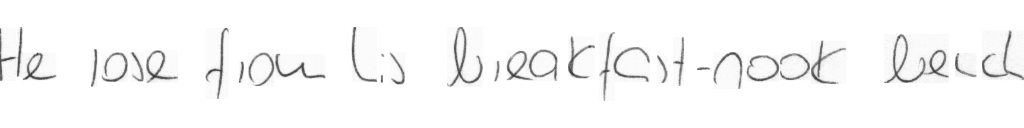

He rose from his breakfast-nook bench
He rose from his breakfast-nook bench 




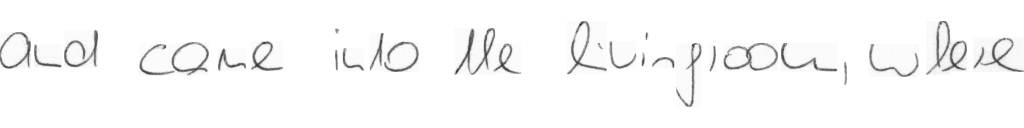

and came into the livingroom , where
and came into the livingston , where 




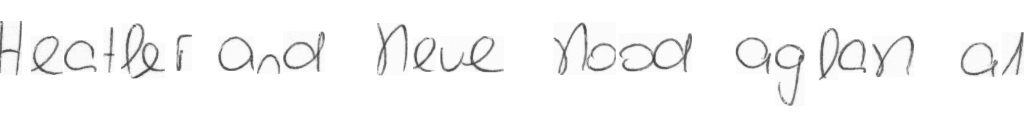

Heather and Steve stood aghast at
Weather and Eve stood aghast at 




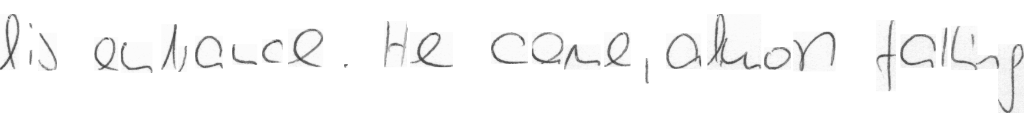

his entrance . He came , almost falling
lis entrance . He can , among falling 




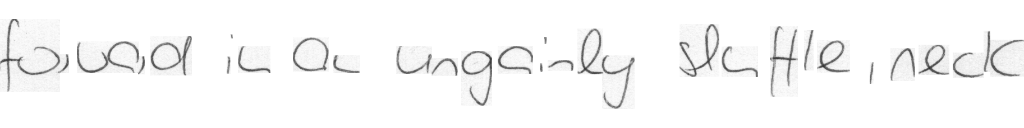

forward in an ungainly shuffle , neck
forward in an ungainly scuffle , neck 




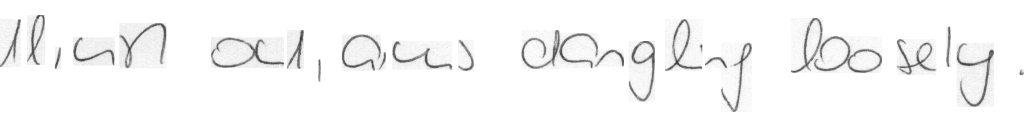

thrust out , arms dangling loosely .
thrust out , arms dangling loosely . 




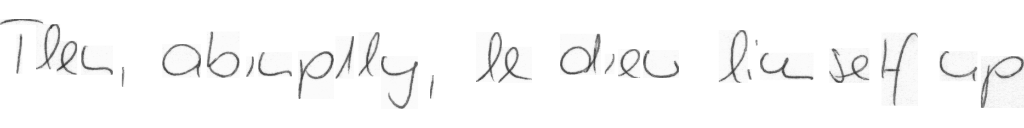

Then , abruptly , he drew himself up
When , abruptly , he drew himself up 




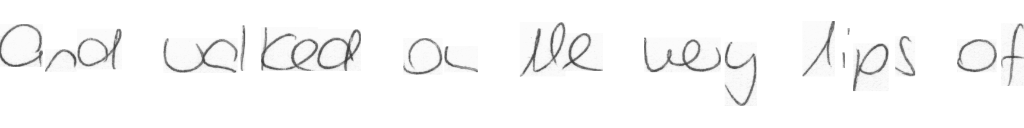

and walked on the very tips of
and looked on He very lips of 




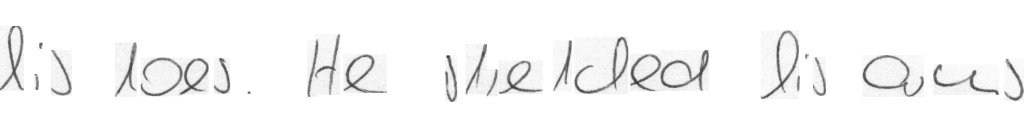

his toes . He stretched his arms
his does . He stretched his as 




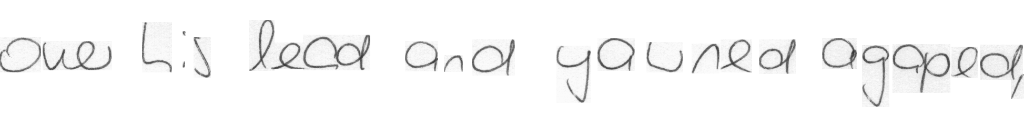

over his head and yawned agape ,
one his lead and yawned gaped , 



In [6]:
from textblob import TextBlob
from data import data_preprocessor as pp
from google.colab.patches import cv2_imshow

start_time = datetime.datetime.now()

test_dgen = DataGenerator_tf(partition='test')

# predict() function will return the predicts with the probabilities
predicts, _ = model.predict(x=test_dgen.create_dataset(),
                            steps=tf.math.ceil(test_dgen.size/test_dgen.batch_size),
                            ctc_decode=True,
                            verbose=1)
# decode to string
predicts = [str(TextBlob(y).correct()) for y in [x[0] for x in test_dgen.tokenizer.sequences_to_texts(predicts)]]
print("Total results:", len(predicts))

ground_truth = [x.decode() for x in test_dgen.labels]

total_time = datetime.datetime.now() - start_time

# mount predict corpus file
with open(os.path.join(output_path, "predict_sentences.txt"), "w") as lg:
    for pd, gt in zip(predicts, ground_truth):
        lg.write(f"TE_L {gt}\nTE_P {pd}\n")
   
for i, item in enumerate(test_dgen.imgs[:10]):
    print("=" * 1024, "\n")
    cv2_imshow(pp.adjust_to_see(item))
    print(ground_truth[i])
    print(predicts[i], "\n")

with open(os.path.join(output_path, "eval_sentences.json"), "w") as f:
  json.dump({"predicts":predicts, "ground_truth":ground_truth}, f)

In [7]:
from data import evaluation

# with open(os.path.join(output_path, "eval.json"), "r") as f:
#   temp = json.load(f)
#   predicts = temp["predicts"]
#   ground_truth = temp["ground_truth"]

evaluate = evaluation.ocr_metrics(predicts, ground_truth)

e_corpus = "\n".join([
    f"Total test images:    {test_dgen.size}",
    f"Total time:           {total_time}",
    f"Time per item:        {total_time / test_dgen.size}\n",
    f"Metrics:",
    f"Character Error Rate: {evaluate[0]:.8f}",
    f"Word Error Rate:      {evaluate[1]:.8f}",
    f"Sequence Error Rate:  {evaluate[2]:.8f}"
])

with open(os.path.join(output_path, "evaluate_sentences.txt"), "w") as lg:
    lg.write(e_corpus)
    print(e_corpus)

Total test images:    1861
Total time:           0:11:13.748142
Time per item:        0:00:00.362036

Metrics:
Character Error Rate: 0.04279086
Word Error Rate:      0.12285107
Sequence Error Rate:  0.61096185
